In [1]:
import mne
import pyxdf
import numpy as np
from mnelab.io.xdf import read_raw_xdf
import scipy

sub = "sub-26"
exp = "fixthemix"

fname = f"{sub}/eeg/{sub}_task-{exp}_eeg.xdf"
fnamePrep = f"derivatives/eegprep/{sub}/{sub}_task-{exp}_eegprep.mat"
#prep_raw = scipy.io.loadmat(fnamePrep)
#adapted from https://mne.discourse.group/t/difficulty-reading-event-ids-from-xdf-file/8186 
names = pyxdf.resolve_streams(fname)
stream_id = pyxdf.match_streaminfos(names, [{"type": "Markers"}, {'type': "EEG"}, {"type": "Audio"}])
original_raw = read_raw_xdf(fname, stream_ids=stream_id, fs_new=1000)
misc_channels = ['BrainAmpSeries-Dev_1-Markers_0','MyAudioStream_0', 'MyAudioStream_1']
audio_channels = ['MyAudioStream_0', 'MyAudioStream_1']
eeg_channels = [i for i in original_raw.ch_names if i not in misc_channels]
data_channels = eeg_channels.copy()
data_channels.extend(audio_channels)



Creating RawArray with float64 data, n_channels=35, n_times=2156115
    Range : 0 ... 2156114 =      0.000 ...  2156.114 secs
Ready.


In [2]:
eeg_data = prep_raw['EEG'][0][0][15]

NameError: name 'prep_raw' is not defined

In [3]:
#compute audio envelope
#adapted from https://stackoverflow.com/questions/30889748/how-to-obtain-sound-envelope-using-python

import matplotlib.pyplot as plt
from scipy.signal import hilbert
from mne.decoding import Scaler
import pandas as pd
import mtrf

%matplotlib qt


#Copy original raw
raw = original_raw.copy()
envelope = raw.copy()
#Grab events
events, event_dict = mne.events_from_annotations(raw)

#Add reference channel back into EEG
envelope = mne.add_reference_channels(envelope, 'Fz')
#Rereference to the average of mastoid channels
envelope.set_eeg_reference(['TP9', 'TP10'])
info = envelope.info

#Remove Nans (replaces them with 0)
envelope = np.nan_to_num(envelope.get_data())
envelope = mne.io.RawArray(envelope, info)

#Compute audio envelope
envelope = envelope.apply_hilbert(picks=audio_channels, envelope=True)
#Filter and resample
envelope = envelope.filter(l_freq=0.1, h_freq=30., picks='eeg')
envelope = envelope.notch_filter(60., picks='eeg')
envelope = envelope.resample(sfreq=250., method='polyphase')

#Store info for future Raw
info = envelope.info
response = envelope.get_data(picks='eeg')
stimulus = envelope.get_data(picks=audio_channels)

#Normalize data
mean = np.average(response, axis=1, keepdims=True)
std = np.std(response, axis=1, keepdims=True)
response = (response - mean)/std

mean = np.average(stimulus, axis=1, keepdims=True)
std = np.std(stimulus, axis=1, keepdims=True)
stimulus = (stimulus - mean)/std

#Split data into smaller segments
#segmentLen is number of sample points per segment
segmentLen = 200*30
response = [response[:, i:i+segmentLen] for i in range(0, len(response[0]), segmentLen)]
stimulus = [stimulus[:, i:i+segmentLen] for i in range(0, len(stimulus[0]), segmentLen)]

if response[-1].shape != response[-2].shape:
    response = response[:-1]
    stimulus = stimulus[:-1]


Used Annotations descriptions: ['0', '1', '11', '12', '13', '14', '15', '2', '21', '22', '23', '24', '25', '3', '31', '33', '35', '4', '41', '43', '44', '45']
Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=36, n_times=2156115
    Range : 0 ... 2156114 =      0.000 ...  2156.114 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Polyphase resampling neighborhood: ±2 input samples


In [4]:
#Paper implementation - Ridge regression

#Adapted from https://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python 
from scipy.sparse import diags
import numpy as np

fs = 250
start = int(np.floor(-0.25*fs))
end = int(np.ceil(0.85*fs))
lags = list(range(int(np.floor(-0.2 * fs)), int(np.ceil(0.8 * fs)) + 1))
n_lags = len(lags)

S = []
for segment in stimulus:
    x = np.array([segment[0]]).T
    n_samples, n_variables = x.shape
    if max(lags) > n_samples:
        raise ValueError("The maximum lag can't be longer than the signal!")
    lag_matrix = np.zeros((n_samples, n_variables * n_lags))

    for idx, lag in enumerate(lags):
        col_slice = slice(idx * n_variables, (idx + 1) * n_variables)
        if lag < 0:
            lag_matrix[0 : n_samples + lag, col_slice] = x[-lag:, :]
        elif lag > 0:
            lag_matrix[lag:n_samples, col_slice] = x[0 : n_samples - lag, :]
        else:
            lag_matrix[:, col_slice] = x

    S.append(lag_matrix)



In [5]:
results = []
n = (S[0].T@S[0]).shape[0]
k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
offset = [-1,0,1]
M = diags(k,offset).toarray()

M[0,0] -= 1
M[-1, -1] -= 1
M /= (1/fs)

for i in range(len(response)):
    results.append(np.linalg.inv(S[i].T@S[i] + 10000.*M)@(S[i].T@response[i].T) / (1/fs))

results = np.average(np.array(results), axis=0)
print(results.shape)

plt.plot(np.linspace(-200, 800, results.shape[0]),results)
plt.show()

(251, 33)


(1535, 16)
10


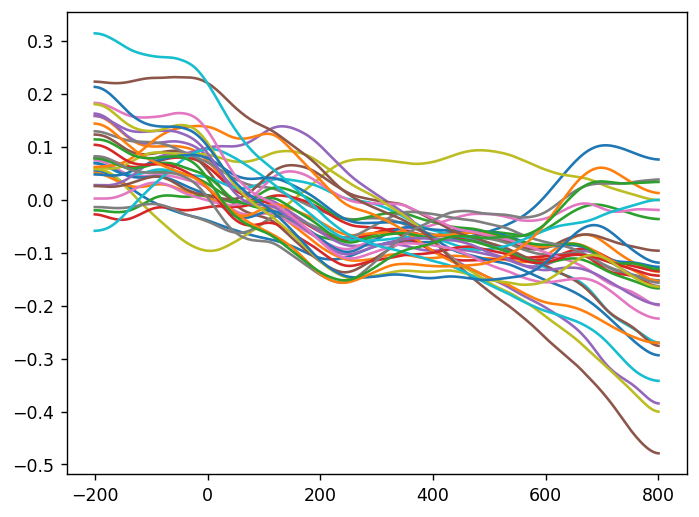

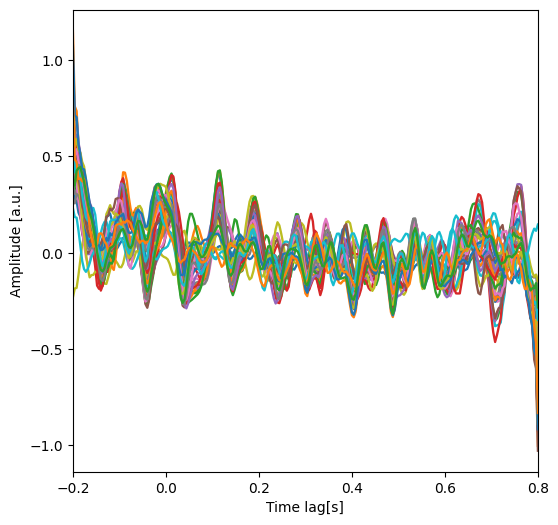

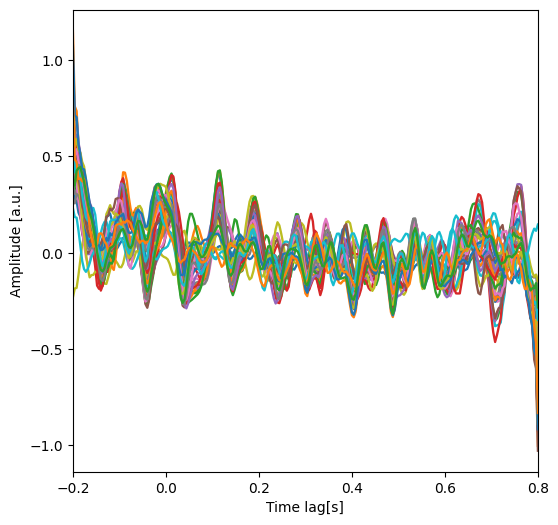

In [6]:
%matplotlib inline
from mtrf.model import load_sample_data

stimulus, response, fs = load_sample_data(n_segments=10, normalize=True)
print(stimulus[-1].shape)
print(len(stimulus))



tmin = -0.200
tmax = 0.800
regularizations = [0., 20., 50., 100., 500., 1000., 2000., 5000., 10000.]

stimulus = envelope.get_data(picks=audio_channels[0]).T
#response = eeg_data[:,:-3].T
response = envelope.get_data(picks='eeg').T

mean = np.average(stimulus, axis=0, keepdims=True)
std = np.std(stimulus, axis=0, keepdims=True)
stimulus = (stimulus - mean)/std


mean = np.average(response, axis=0, keepdims=True)
std = np.std(response, axis=0, keepdims=True)
response = (response - mean)/std

# stimulus = list(stimulus.reshape((128, 3970, 1)))
# response = list(response.reshape((128, 3970, 31)))

fwd_trf = mtrf.model.TRF(direction=1)

from mtrf.stats import crossval

best = None
best_score = -np.inf

# for i in regularizations:
#     fwd_trf.train(stimulus, response, fs=250, tmin=tmin, tmax=tmax, regularization=i)
#     r_fwd = crossval(fwd_trf, stimulus, response, 500, tmin, tmax, i, k=10)
#     print(f"mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")

#     if r_fwd.mean() > best_score:
#         best_score = r_fwd.mean()
#         best = i

# print(f"Best regularization parameter: {best} with score of {best_score}")

# fwd_trf.train(stimulus, response, fs=250, tmin=tmin, tmax=tmax, regularization=best)
fwd_trf.train(stimulus, response, fs=250, tmin=tmin, tmax=tmax, regularization = 100.)
fwd_trf.plot()

In [ ]:
# #Paper implementation no regularization
# start = -200
# end = 800

# eegNorm = envelope.copy()

# stim = eegNorm.get_data(picks=[33])[0]
# numSamp = len(stim)
# #eegNorm.plot(picks=33)

# # startLag = before.shape[1] - stim.shape[1]
# # endLag = after.shape[1] - stim.shape[1]

# S = np.zeros((numSamp, end-start))
# print(stim[-start:numSamp].shape)
# for i in range(-start):
#     S[:numSamp+start+i, i] = stim[-start-i:numSamp]
# S[:, -start] = stim
# for i in range(end):
#     S[i:numSamp, i-start] = stim[:numSamp-i]

# S=np.hstack((np.ones((S.shape[0], 1)), S))
# R = eegNorm.get_data(picks=['eeg']).T
# print(R.shape)
# print(S.shape)


In [ ]:
#Paper implementation - Ridge regression

#Adapted from https://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python 
from scipy.sparse import diags
import numpy as np

start = int(np.floor(-0.2*250))
end = int(np.ceil(0.8*250))

eegNorm = envelope.copy()
stim = envelope.get_data(picks=audio_channels)[0]
numSamp = len(stim)
#eegNorm.plot(picks=33)

# startLag = before.shape[1] - stim.shape[1]
# endLag = after.shape[1] - stim.shape[1]

S = np.zeros((numSamp, end-start))
print(stim[-start:numSamp].shape)
for i in range(-start):
    S[:numSamp+start+i, i] = stim[-start-i:numSamp]
for i in range(end):
    S[i:numSamp, i-start] = stim[:numSamp-i]
fs = 250.
lags = list(range(int(np.floor(-0.2 * fs)), int(np.ceil(0.8 * fs)) + 1))
x = np.array([envelope.get_data(picks=audio_channels)[0]]).T


n_lags = len(lags)
print(n_lags)
n_samples, n_variables = x.shape
print(n_samples)
if max(lags) > n_samples:
    raise ValueError("The maximum lag can't be longer than the signal!")
lag_matrix = np.zeros((n_samples, n_variables * n_lags))

for idx, lag in enumerate(lags):
    col_slice = slice(idx * n_variables, (idx + 1) * n_variables)
    if lag < 0:
        lag_matrix[0 : n_samples + lag, col_slice] = x[-lag:, :]
    elif lag > 0:
        lag_matrix[lag:n_samples, col_slice] = x[0 : n_samples - lag, :]
    else:
        lag_matrix[:, col_slice] = x

S=np.hstack((np.ones((S.shape[0], 1)), S))
R = eegNorm.get_data(picks=['eeg']).T
#R = eeg_data[:,:-3].T
print(R.shape)
#S = lag_matrix
print(S.shape)
print(S)




(508110,)
251
508160
(508160, 33)
(508160, 251)
[[ 1.         -0.98868067 -0.98368177 ...  0.          0.
   0.        ]
 [ 1.         -0.98427814 -0.98868067 ...  0.          0.
   0.        ]
 [ 1.         -0.98090039 -0.98427814 ...  0.          0.
   0.        ]
 ...
 [ 1.          0.          0.         ... -0.98038982 -0.98760382
  -0.98835895]
 [ 1.          0.          0.         ... -0.98361729 -0.98038982
  -0.98760382]
 [ 1.          0.          0.         ... -0.98464253 -0.98361729
  -0.98038982]]


In [ ]:
threshold = 0.1
data = eegNorm.get_data(picks=eeg_channels)

mask = np.ones(data.shape[1])
for channel in range(data.shape[0]):

    first = data[channel][0]
    for sample in range(1,data.shape[1]):
        
        if np.abs(first - data[channel][sample]) >= threshold:
            mask[sample] = 0.

        first = data[channel][sample]

print(np.sum(mask), data.shape[1])

119909.0 508160


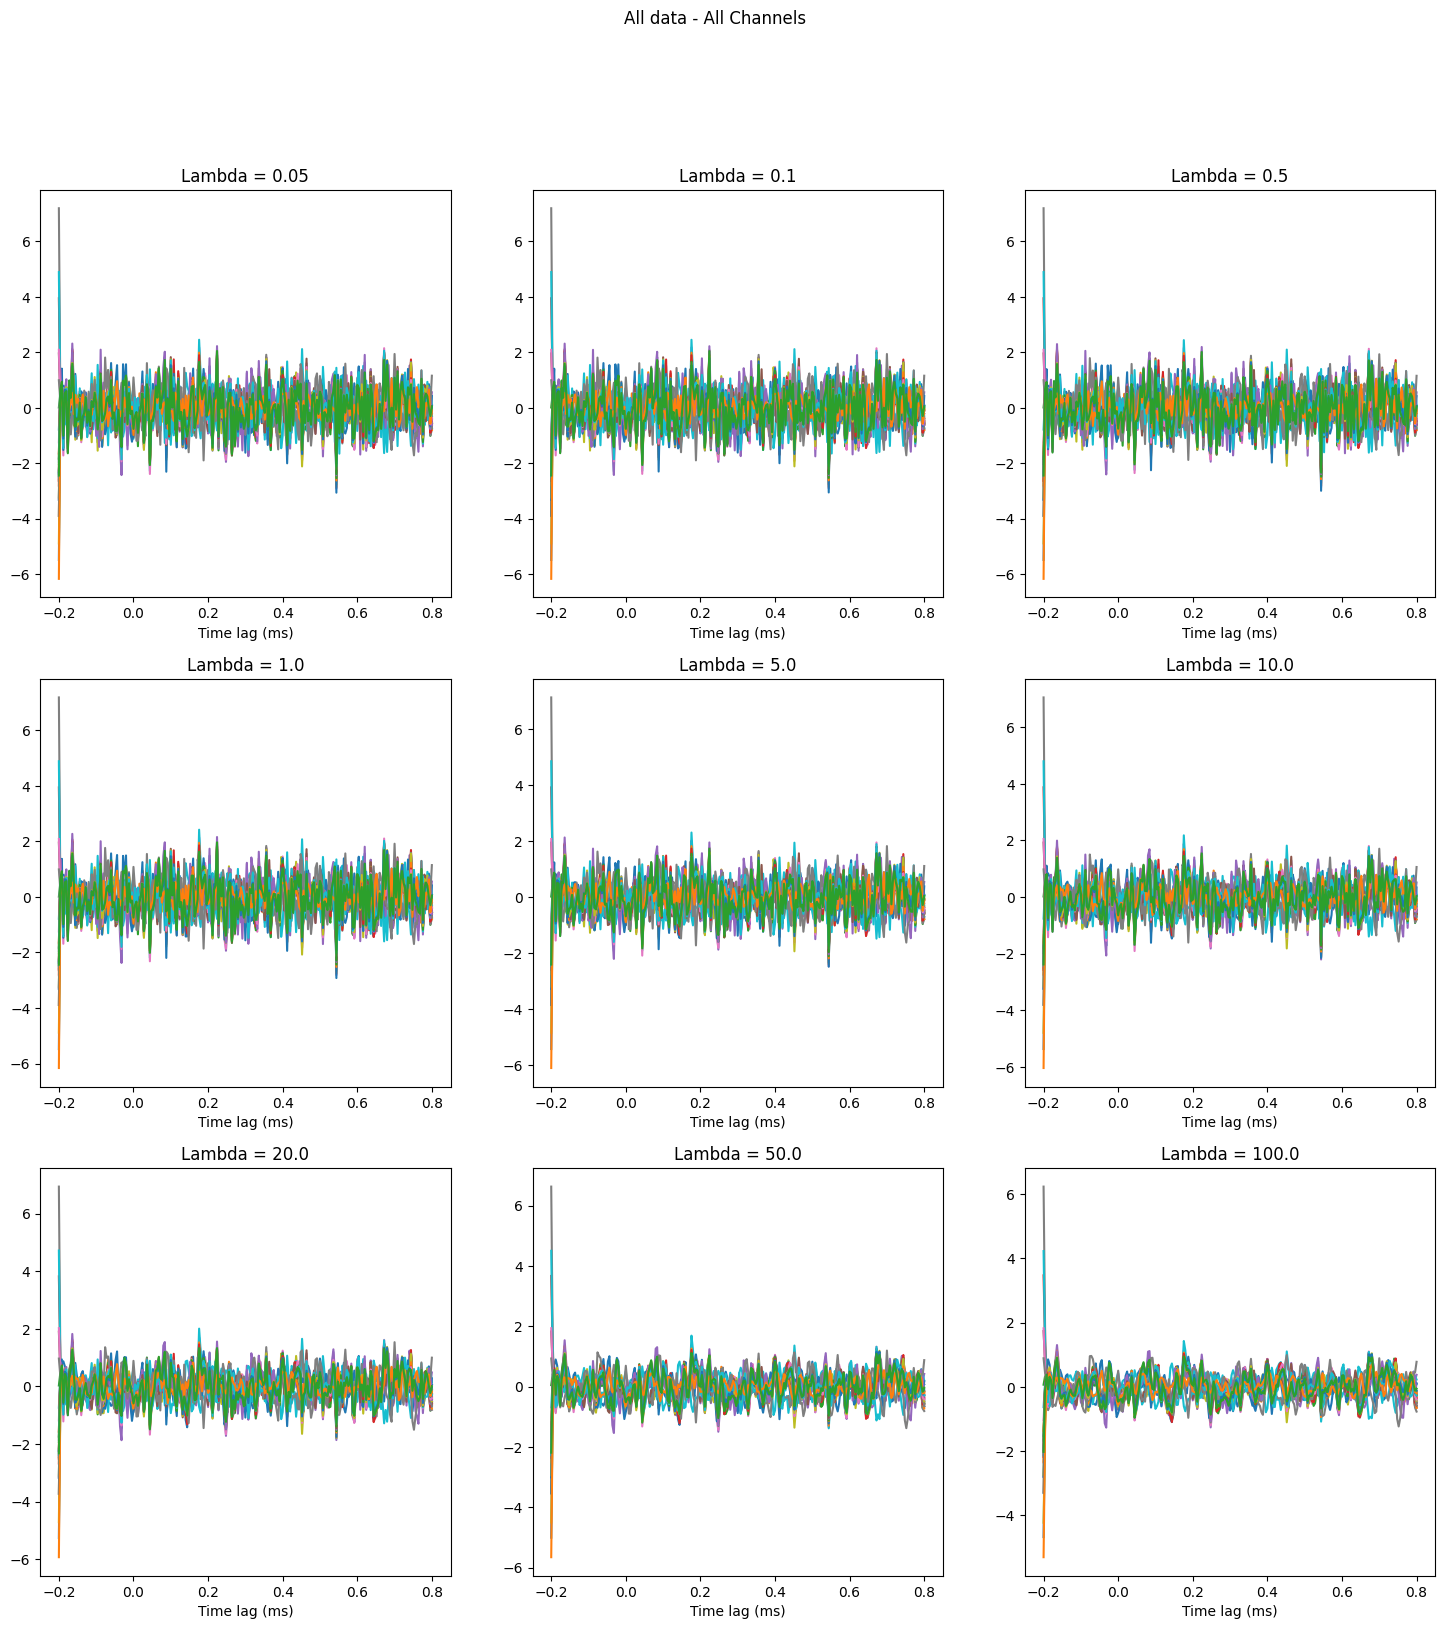

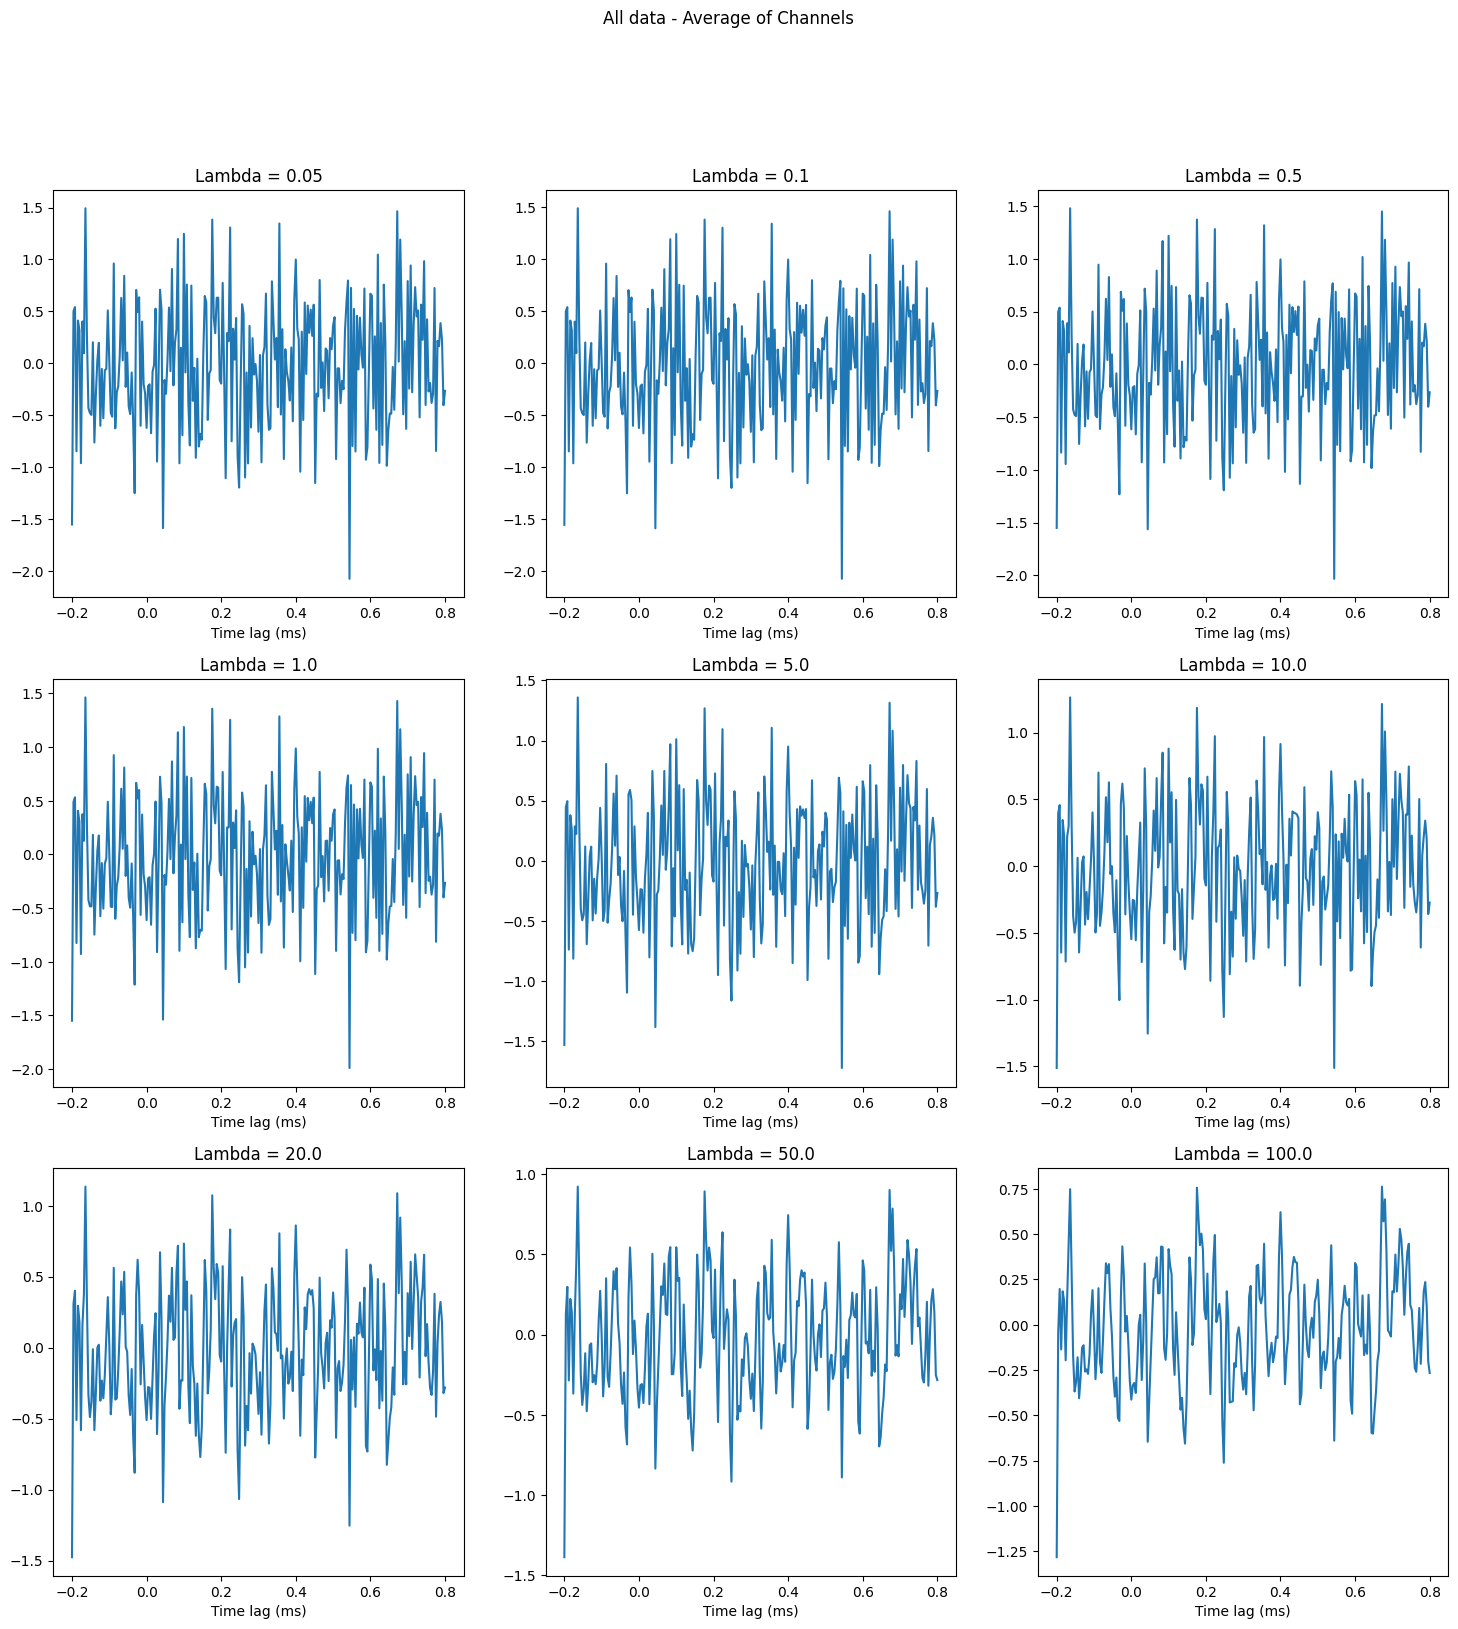

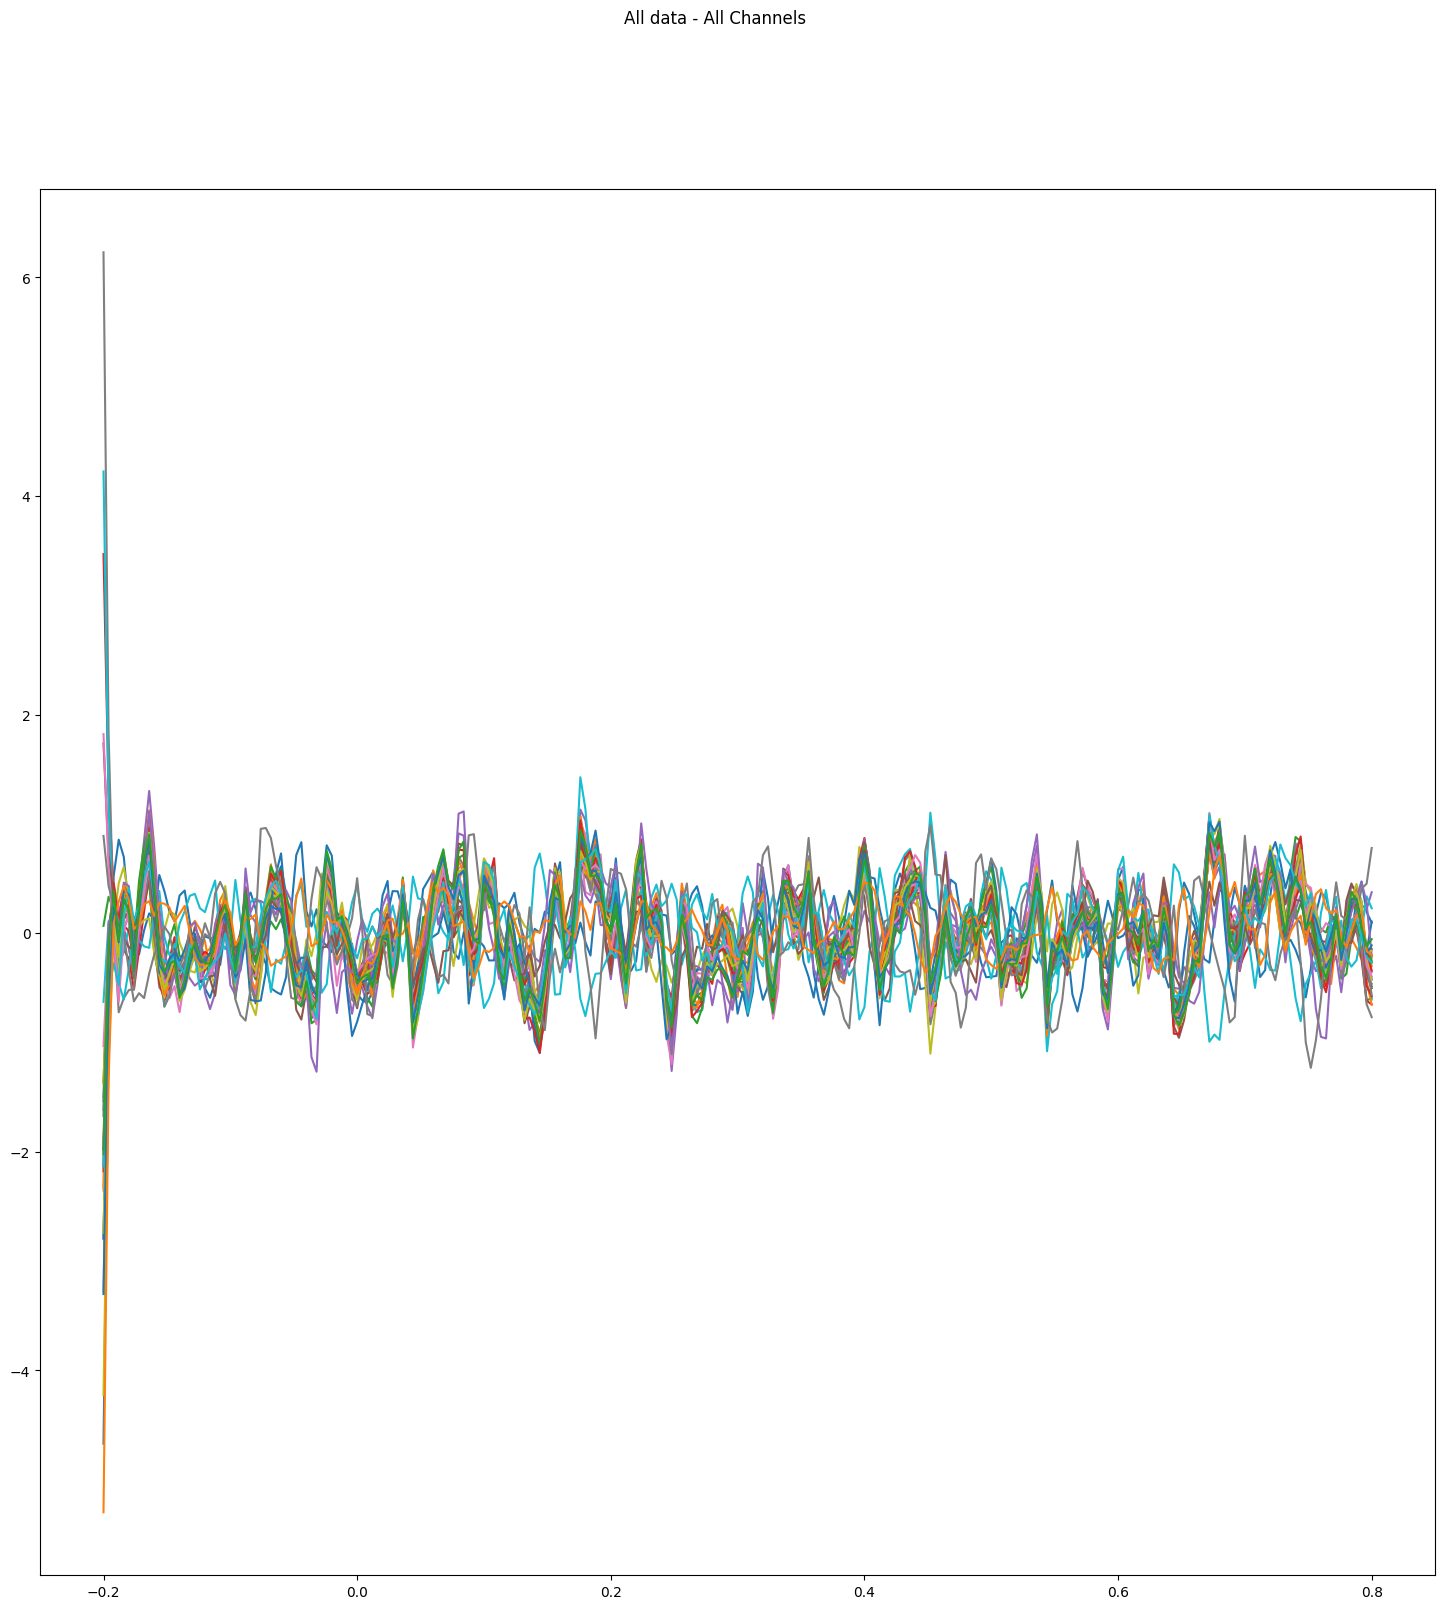

In [ ]:
n = (S.T@S).shape[0]
k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
offset = [-1,0,1]
M = diags(k,offset).toarray()

M[0,0] -= 1
M[-1, -1] -= 1
M /= (1/fs)

lambdas = np.array([0.05, 0.1, 0.5, 1., 5., 10., 20., 50., 100.])


times=np.array(lags)/fs
S_orig = S.copy()
S = np.multiply(S_orig, (np.atleast_2d(mask).T))
outerTerm = S.T@R
innerTerm = S.T@S
ind = len(lambdas)//3

fig, axs = plt.subplots(3, ind)
fig.set_size_inches(6*ind, 6*ind)
fig.suptitle('All data - All Channels')
for i, l in enumerate(lambdas):
    W = np.linalg.inv(innerTerm + l*M)@outerTerm / (1/fs)
    if l == 5.:
        W_keep = W.copy()
    axs[i//ind, i%ind].plot(times, W)
    axs[i//ind, i%ind].set_title(f'Lambda = {l}')
    axs[i//ind, i%ind].set_xlabel('Time lag (ms)')

plt.show()

fig, axs = plt.subplots(3, ind)
fig.set_size_inches(6*ind, 6*ind)
fig.suptitle('All data - Average of Channels')
for i, l in enumerate(lambdas):
    W = np.linalg.inv(innerTerm + l*M)@outerTerm / (1/fs)
    axs[i//ind, i%ind].plot(times, np.average(W, axis=1))
    axs[i//ind, i%ind].set_title(f'Lambda = {l}')
    axs[i//ind, i%ind].set_xlabel('Time lag (ms)')

plt.show()

fig, axs = plt.subplots(1)
fig.set_size_inches(6*ind, 6*ind)
fig.suptitle('All data - All Channels')
W = np.linalg.inv(innerTerm + 100.*M)@outerTerm / (1/fs)
axs.plot(times, W)

plt.show()
 


In [ ]:
# #Paper implementation - Ridge regression
# # SONG 1

# #Adapted from https://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python 
# from scipy.sparse import diags
# import numpy as np

# start = -200
# end = 800

# ind = np.where(events[:,2] == 2)

# start_ind = ind[0][0]
# end_ind = ind[0][1]

# eegNorm = envelope.copy()

# stim = eegNorm.get_data(picks=audio_channels, tmin=events[start_ind][0]/1000, tmax=events[end_ind][0]/1000)[0]
# numSamp = len(stim)
# #eegNorm.plot(picks=33)

# # startLag = before.shape[1] - stim.shape[1]
# # endLag = after.shape[1] - stim.shape[1]

# S = np.zeros((numSamp, end-start))
# print(stim[-start:numSamp].shape)
# for i in range(-start):
#     S[:numSamp+start+i, i] = stim[-start-i:numSamp]
# S[:, -start] = stim
# for i in range(end):
#     S[i:numSamp, i-start] = stim[:numSamp-i]

# S=np.hstack((np.ones((S.shape[0], 1)), S))
# R = eegNorm.get_data(picks=['eeg'], tmin=events[start_ind][0]/1000, tmax=events[end_ind][0]/1000).T
# print(R.shape)
# print(S.shape)





In [ ]:
# threshold = 1.
# data = R.T

# mask = np.ones(data.shape[1])
# for channel in range(data.shape[0]):

#     first = data[channel][0]
#     for sample in range(1,data.shape[1]):
        
#         if np.abs(first - data[channel][sample]) >= threshold:
#             mask[sample] = 0.

#         first = data[channel][sample]

# print(np.sum(mask), data.shape[1])

In [ ]:
# n = (S.T@S).shape[0]
# k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
# offset = [-1,0,1]
# M = diags(k,offset).toarray()

# M[0,0] -= 1
# M[-1, -1] -= 1

# lambdas = [0.05, 0.1, 0.5, 1., 5., 10., 20., 50., 100.]
# S_orig = S.copy()
# S = np.multiply(S_orig, (np.atleast_2d(mask).T))
# print(S)

# outerTerm = S.T@R
# innerTerm = S.T@S
# ind = len(lambdas)//3

# fig, axs = plt.subplots(3, ind)
# fig.set_size_inches(6*ind, 6*ind)
# fig.suptitle('First Song - All Channels')
# for i, l in enumerate(lambdas):
#     W = np.linalg.inv(innerTerm + l*M)@outerTerm
#     axs[i//ind, i%ind].plot(np.linspace(start, end, W.shape[0]), W)
#     axs[i//ind, i%ind].set_title(f'Lambda = {l}')
#     axs[i//ind, i%ind].set_xlabel('Time lag (ms)')

# plt.show()

# fig, axs = plt.subplots(3, ind)
# fig.set_size_inches(6*ind, 6*ind)
# fig.suptitle('First Song - Average of Channels')
# for i, l in enumerate(lambdas):
#     W = np.linalg.inv(innerTerm + l*M)@outerTerm
#     axs[i//ind, i%ind].plot(np.linspace(start, end, W.shape[0]), np.average(W, axis=1))
#     axs[i//ind, i%ind].set_title(f'Lambda = {l}')
#     axs[i//ind, i%ind].set_xlabel('Time lag (ms)')

# plt.show()

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\malco\AppData\Local\Temp\ipykernel_18976\3640553963.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
C:\Users\malco\AppData\Local\Temp\ipykernel_18976\3640553963.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
c:\Users\malco\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


ValueError: ch_types and ch_names must be the same length (32 != 33) for ch_types=['eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg'
 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg'
 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg' 'eeg']

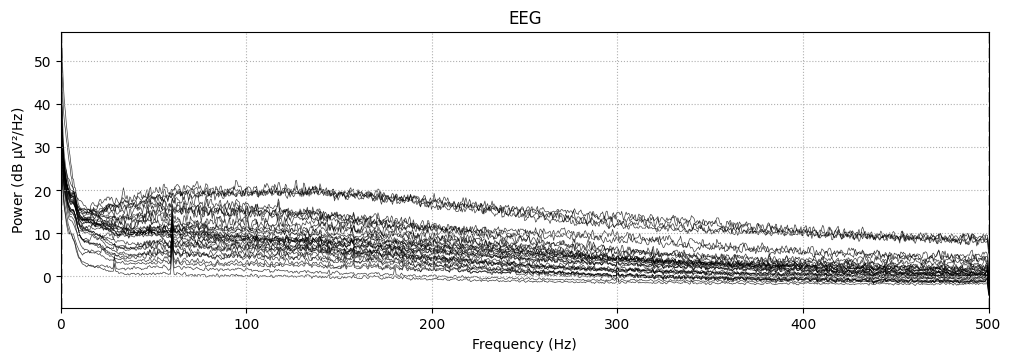

In [ ]:
raw.compute_psd().plot()

not_these = ['MyAudioStream_0', 'MyAudioStream_1', 'BrainAmpSeries-Dev_1-Markers_0']
these = [i for i in envelope.ch_names if i not in not_these]
info = mne.create_info(ch_names = these, sfreq=250, ch_types=['eeg' for i in range(32)])
print(raw.ch_names)
print(info.ch_names)
sensorData = mne.io.RawArray(W_keep.T, info)
sensorData.set_montage('brainproducts-RNP-BA-128', on_missing='ignore')
sensorData = sensorData.compute_psd()
sensorData.plot_topomap()

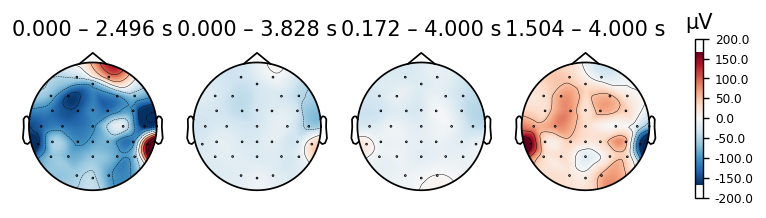

In [ ]:
not_these = ['MyAudioStream_0', 'MyAudioStream_1', 'BrainAmpSeries-Dev_1-Markers_0']
these = [i for i in envelope.ch_names if i not in not_these]
info = mne.create_info(ch_names = these, sfreq=250, ch_types=['eeg' for i in range(32)])
dat = mne.EvokedArray(W_keep.T, info)
dat.set_montage('brainproducts-RNP-BA-128', on_missing='ignore')
dat.plot_topomap( average=5.)